In [ ]:
# Mounting google drive
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
# We use this library to move the data in colab environment
import shutil 

# Load the train dataset
# Specify the source file path in your Colab environment
source_file_path = '/content/drive/MyDrive/DataChallenge_augmentedFiles/train_rsz.zip'

# Specify the destination file path in your Google Drive
destination_file_path = '/content/train_rsz.zip'

# Copy the file from the source path to the destination path
shutil.copyfile(source_file_path, destination_file_path)

# load the validation dataset
source_file_path = '/content/drive/MyDrive/DataChallenge_augmentedFiles/val_rsz.zip'
# Specify the destination file path in your Google Drive
destination_file_path = '/content/val_rsz.zip'

# Copy the file from the source path to the destination path
shutil.copyfile(source_file_path, destination_file_path)


'/content/val_rsz.zip'

In [ ]:
# Unzip the datasets
!unzip train_rsz.zip
# !unzip '/content/Vague.zip' -d "/content/add_data"
!unzip val_rsz

Streaming output truncated to the last 5000 lines.
  inflating: train/OK/letter_CH176FC1_333884_0_RESPONSIVITE_1.png  
  inflating: train/OK/letter_CH176FC1_334696_0_RESPONSIVITE_1.png  
  inflating: train/OK/letter_CH176FC1_334708_0_RESPONSIVITE_1.png  
  inflating: train/OK/letter_CH176FC1_334734_0_RESPONSIVITE_1.png  
  inflating: train/OK/letter_CH176FC1_338106_0_RESPONSIVITE_1.png  
  inflating: train/OK/letter_CH176FC1_338107_0_RESPONSIVITE_1.png  
  inflating: train/OK/letter_CH176FC1_338110_0_RESPONSIVITE_1.png  
  inflating: train/OK/letter_CH176FC1_338113_0_RESPONSIVITE_1.png  
  inflating: train/OK/letter_CH176FC1_338407_0_RESPONSIVITE_1.png  
  inflating: train/OK/letter_CH176FC1_338412_0_RESPONSIVITE_1.png  
  inflating: train/OK/letter_CH176FC1_338425_0_RESPONSIVITE_1.png  
  inflating: train/OK/letter_CH176FC1_338426_0_RESPONSIVITE_1.png  
  inflating: train/OK/letter_CH176FC1_338431_0_RESPONSIVITE_1.png  
  inflating: train/OK/letter_CH176FC1_338432_0_RESPONSIVITE_1.png

In [ ]:
# Importing libraries
import numpy as np
import os
import tensorflow as tf
import pathlib
import matplotlib.pyplot as plt
from tensorflow.keras.utils import to_categorical
from tensorflow.keras.applications.resnet import ResNet50
from tensorflow.keras.applications.xception import Xception
from tensorflow.keras.applications import InceptionResNetV2
from tensorflow.keras.applications import ResNet101 # We used vgg16,vgg19,resnet50,inceptionV3 and mobilenet but Resnet101 is the best
from tensorflow.keras.layers import Dense, Flatten
from tensorflow.keras.models import Model
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from keras import Sequential, layers
from keras.layers import Conv2D
from keras.layers import MaxPooling2D
from keras.layers import Dropout
from keras.optimizers import SGD
from keras.layers import Rescaling
import matplotlib.pyplot as plt
from keras.callbacks import EarlyStopping
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras.layers import Lambda

In [ ]:
# Specifications
batch_size = 16
img_height = 512
img_width = 640

# #Load dataset
# train_dir = pathlib.Path('/content/Aug/dataset_2')


# train_ds = tf.keras.utils.image_dataset_from_directory(
#   train_dir,
#   image_size= (512, 640),
#   label_mode = 'categorical',
#   color_mode = "grayscale",
#   batch_size=batch_size)

# WITHOUT 
# Loading the train dataset
train_dir = pathlib.Path('/content/train')

train_ds = tf.keras.utils.image_dataset_from_directory(
  train_dir,
  image_size= (512, 640), # size of the images in the dataset
  label_mode = 'categorical',
  color_mode = "grayscale",
  batch_size=batch_size)



# Loading the validation dataset
val_dir =  pathlib.Path('/content/val')
val_ds = tf.keras.utils.image_dataset_from_directory(
  val_dir,
  image_size= (512, 640),
  label_mode = 'categorical',
  color_mode = "grayscale",
  batch_size=batch_size)



Found 4431 files belonging to 2 classes.
Found 1107 files belonging to 2 classes.


In [ ]:
## This cell is to check the images in training datset and validation dataset to see if there are common images between them

# Get the file names from the training dataset
train_filenames = [str(pathlib.Path(path).name) for path in train_ds.file_paths]

# Get the file names from the validation dataset
val_filenames = [str(pathlib.Path(path).name) for path in val_ds.file_paths]

# Convert the file names to sets
train_set = set(train_filenames)
val_set = set(val_filenames)

# Find the intersection of the two sets
common_images = train_set.intersection(val_set)

# Check if the intersection is empty
if len(common_images) == 0:
    print("No common images between training and validation datasets.")
else:
    print("Common images found between training and validation datasets:", common_images)

No common images between training and validation datasets.


In [ ]:

# Load the pre-trained ResNet50 model
resnet = ResNet101(weights='imagenet', include_top=False, input_shape=(img_height, img_width, 3))

# Freeze the pre-trained layers
for layer in resnet.layers:
    layer.trainable = False

# Since our dataset is grayscale images and the model is pretrained on RGB images we use this function to convert them to RGB and then pass them through the model
# Convert grayscale to RGB 
def grayscale_to_rgb(image):
    return tf.image.grayscale_to_rgb(image)

# Add new layers for your own dataset
inputs = tf.keras.Input(shape=(img_height, img_width, 1))
rgb_images = Lambda(grayscale_to_rgb)(inputs)
x = resnet(rgb_images)
x = Flatten()(x)
x = Dense(1024, activation='relu')(x)
x = Dropout(0.25)(x)
x = Dense(512, activation='relu')(x)
x = Dropout(0.25)(x)
x = Dense(256,activation='relu')(x)
x = Dropout(0.25)(x)
predictions = Dense(2, activation='softmax')(x)

# Create a new model
model = Model(inputs=inputs, outputs=predictions)
opt = tf.keras.optimizers.experimental.AdamW()


# This function manages the learning rate of the model and minimizes it as epoch gets bigger
def scheduler(epoch, lr):
   if epoch < 5:
     return lr
   else:
     return lr * tf.math.exp(-0.1)
callback = tf.keras.callbacks.LearningRateScheduler(scheduler)
# Compile the model
model.compile(optimizer= 'adam', loss='categorical_crossentropy', 
              metrics=['accuracy',
              keras.metrics.TruePositives(name='tp'),
              keras.metrics.FalsePositives(name='fp'),
              keras.metrics.TrueNegatives(name='tn'),
              keras.metrics.FalseNegatives(name='fn'), 
              keras.metrics.Precision(name='precision', class_id = 1),
              keras.metrics.Recall(name='recall', class_id= 1)])





171446536/171446536 [==============================] - 6s 0us/step


In [ ]:
from tensorflow.keras.callbacks import ModelCheckpoint

# Define the checkpoint path and format
checkpoint_path = "model_checkpoint_{epoch:02d}.h5"

# Create the ModelCheckpoint callback
checkpoint_callback = ModelCheckpoint(checkpoint_path, save_weights_only=True, save_freq='epoch', period=1)


In [ ]:
# Train the model
# earlystop_callback = tf.keras.callbacks.EarlyStopping(monitor='val_loss', patience=5)


history = model.fit(
  train_ds,
  validation_data=val_ds,
  epochs=25,
  batch_size=batch_size,
  class_weight = {0:0.25, 1:1},  # For the augmented dataset we change class weight to 0:0.5, 1:1
  callbacks=[callback, checkpoint_callback]

)


Epoch 1/25
277/277 [==============================] - 93s 274ms/step - loss: 13.1924 - accuracy: 0.7172 - tp: 3178.0000 - fp: 1253.0000 - tn: 3178.0000 - fn: 1253.0000 - precision: 0.2186 - recall: 0.5130 - val_loss: 1.6299 - val_accuracy: 0.6251 - val_tp: 692.0000 - val_fp: 415.0000 - val_tn: 692.0000 - val_fn: 415.0000 - val_precision: 0.2636 - val_recall: 0.9355 - lr: 0.0010
Epoch 2/25
277/277 [==============================] - 80s 288ms/step - loss: 0.4944 - accuracy: 0.7707 - tp: 3415.0000 - fp: 1016.0000 - tn: 3415.0000 - fn: 1016.0000 - precision: 0.2983 - recall: 0.6519 - val_loss: 1.0853 - val_accuracy: 0.2945 - val_tp: 326.0000 - val_fp: 781.0000 - val_tn: 326.0000 - val_fn: 781.0000 - val_precision: 0.1634 - val_recall: 0.9806 - lr: 0.0010
Epoch 3/25
277/277 [==============================] - 76s 275ms/step - loss: 0.3090 - accuracy: 0.7861 - tp: 3483.0000 - fp: 948.0000 - tn: 3483.0000 - fn: 948.0000 - precision: 0.3050 - recall: 0.5907 - val_loss: 0.6369 - val_accuracy: 0.

In [ ]:

# Define the source and destination paths
source_path = "/content/model_checkpoint_21.h5"
destination_path = "/content/drive/MyDrive/DataChallenge_augmentedFiles/model_checkpoint_21.h5"

# Move the file
shutil.move(source_path, destination_path)

'/content/drive/MyDrive/DataChallenge_augmentedFiles/model_checkpoint_21.h5'

In [ ]:
# Define the source and destination paths
source_path = "/content/model_checkpoint_17.h5"
destination_path = "/content/drive/MyDrive/DataChallenge_augmentedFiles/model_checkpoint_17.h5"

# Move the file
shutil.move(source_path, destination_path)

FileNotFoundError: ignored

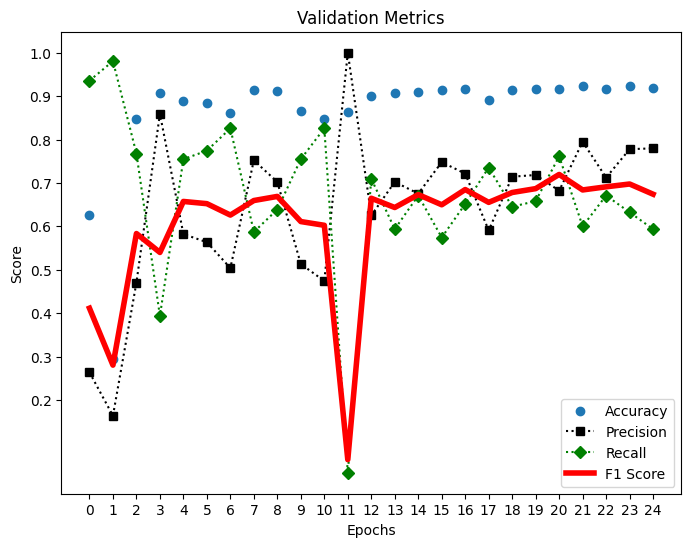

In [ ]:
import matplotlib.pyplot as plt

# Get accuracy values from history
val_accuracy = history.history['val_accuracy']

# Get precision values from history
val_precision = history.history['val_precision']

# Get recall values from history
val_recall = history.history['val_recall']

# Calculate F1_score
f1_score = [2 * (recall * precision) / (recall + precision) for recall, precision in zip(val_recall, val_precision)]

# Plotting
plt.figure(figsize=(8, 6))
plt.plot(val_accuracy,marker='o',linestyle='None', label='Accuracy')
plt.plot(val_precision,marker='s',linestyle=':', label='Precision',color='black')
plt.plot(val_recall,marker='D',linestyle='dotted', label='Recall',color='green')
plt.plot(f1_score, label='F1 Score',linewidth=4,color='red')
plt.xlabel('Epochs')
plt.ylabel('Score')
plt.title('Validation Metrics')

# Customizing x-axis and y-axis ticks
x_ticks = [i for i in range(len(val_accuracy))]  # Example: Use epoch numbers as x-axis ticks
  # Example: Custom y-axis ticks
plt.xticks(x_ticks)
y_ticks = np.arange(0.2, 1.1, 0.1)
plt.yticks(y_ticks)

plt.legend()
plt.show()
